# SSMF-Task: Training of an SNN Demapper with Tenary Encoding

In this example we train SNN-based demapp with a single hidden LIF layer and a non-spiking integrator voting layer to solve the SSMF-Task [1]. The SNN demapper used in this example is based on [2].

### References
[1] Elias Arnold, Eike-Manuel Edelmann, Alexander von Bank, Eric Müller, Laurent Schmalen, Johannes Schemmel, Short-reach Optical Communications: A Real-world Task for Neuromorphic Hardware. [https://arxiv.org/abs/2412.03129](https://arxiv.org/abs/2412.03129)

[2] Eike-Manuel Bansbach; Alexander von Bank; Laurent Schmalen. Spiking Neural Network Decision Feedback Equalization. [https://ieeexplore.ieee.org/abstract/document/10104550](https://ieeexplore.ieee.org/abstract/document/10104550)


In [59]:
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import numpy as np
import torch
import norse.torch as norse

from IMDD import IMDDModel, SSMFDataset, helpers

## Tenary Encoding

In [60]:
dataset = SSMFDataset(train=True)

# Generate some data
y_chunk, q = dataset[45]

# Data
print("Received symbols y (chunked):\n\t", y_chunk, y_chunk.shape)
print("Corresponding index q:\n\t", q, q.shape)
print("Corresponding send bits:\n\t", helpers.get_graylabel(2)[q])

Received symbols y (chunked):
	 tensor([3.2442, 1.1051, 3.9311, 4.6754, 3.5988, 3.4377, 3.0124, 1.2034, 4.2148,
        5.0880, 4.3835, 3.3564, 3.6701, 2.9727, 2.4524, 4.9323, 2.4587, 0.8778,
        2.1116, 3.3859, 4.1223]) torch.Size([21])
Corresponding index q:
	 tensor(3) torch.Size([])
Corresponding send bits:
	 tensor([1, 0], dtype=torch.uint8)


In [61]:
# Word lenght of the quantizer
K = 8

# Maximum input value of the quantizer
x_max = 4

# Time resolution of encoding and SNN
dt = 1e-3
time_length = 0.01  # s

In [62]:
class BitMapper:
    """ Bit mapper class """

    def __init__(self, w, device):
        if(w <= 0):
            raise ValueError("w has to be larger than 0")
        self.device = device
        self.word_length = w
        self.change()

    def change(self):
        self.map_mat = torch.linspace(0, self.word_length - 1, self.word_length).to(self.device)
        self.map_mat = 2**self.map_mat

    def map(self, bits):
        numbers = self.map_mat @ torch.flip(bits, dims=[1]).T
        return numbers
 
    def demap(self, numbers):
        orig_shape = numbers.shape
        numbers = numbers.flatten()
        bit_list = [(numbers >> shift_ind) & 1 for shift_ind in range(self.word_length)] # little endian
        bit_list.reverse() # big endian
        bits = torch.zeros((self.word_length, numbers.shape[0]), device=self.device)
        for n in range(len(bit_list)):
            bits[n] = bit_list[n]
        bits = bits.T
        bits = bits.unflatten(0, (orig_shape))

        return bits


def midtread_binary_unipolar(x, w, x_max):
    x = torch.clip(x, 0, x_max)
    delta_x = x_max / (2**w)
    # Select class from +/- 2**w-1/2
    xh_uniform_midtread = torch.floor(torch.abs(x) / delta_x + 0.5)
    # Clip to 2**w-1
    xh_uniform_midtread = torch.clip(xh_uniform_midtread, 0, 2**w - 1)
    # Round up
    xh_uniform_midtread = torch.ceil(xh_uniform_midtread).int()

    return delta_x, xh_uniform_midtread

In [63]:
class Ternary_Encoder(torch.nn.Module):
    """ Class implementing the transmitter model """

    def __init__(self, word_length: int = 8, time: int = 10, maximum_input_absolute: int = 4,
                 device: torch.device ='cpu'):
        super().__init__()
        self.w = word_length
        self.T = time
        self.x_max = maximum_input_absolute
        self.bitmap = BitMapper(self.w, device)
        self.device = device

    def forward(self, recv_symbols):
        rx = recv_symbols - torch.mean(recv_symbols)
        d_x, recv_q = midtread_binary_unipolar(torch.abs(rx), self.w, self.x_max)
        binary = self.bitmap.demap(recv_q)
        sign = torch.permute(torch.sign(rx).repeat(self.w, 1, 1), (1, 2, 0))
        tern_in_sym = binary * sign
        inputs = tern_in_sym.reshape((1, tern_in_sym.shape[0], -1))
        inputs = torch.vstack(
            (inputs, torch.zeros(
                (self.T - 1, inputs.shape[1], inputs.shape[2]), device=self.device)))

        return inputs


encoder = Ternary_Encoder(
    word_length=K,
    time=int(time_length // dt),
    maximum_input_absolute=x_max,
    device='cpu')

In [64]:
spikes = encoder(y_chunk.unsqueeze(0))  # first ten samples
print("Spikes:\n", spikes, spikes.shape)

Spikes:
 tensor([[[-0., -0., -0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]]) torch.Size([10, 1, 168])


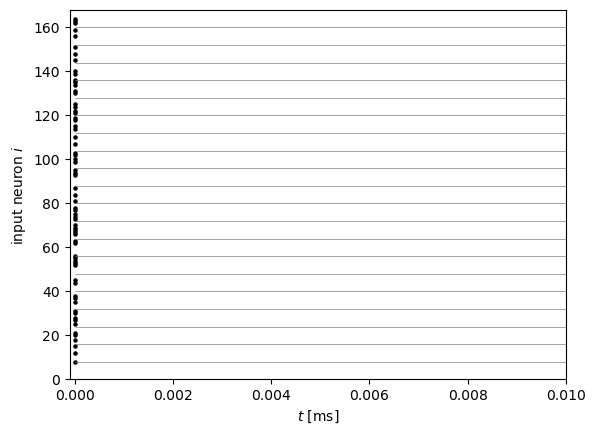

In [65]:
# Convert time-dense spikes into event-based spikes
events = torch.nonzero(spikes[:, 0])
time = np.linspace(0, time_length, int(time_length / dt))

fig, axes = plt.subplots()
axes.set_xlim(-0.0001, time_length)
axes.set_ylim(0, 21 * K)
axes.set_xlabel("$t$ [ms]")
axes.set_ylabel("input neuron $i$")
axes.scatter(events[:, 0] * dt, events[:, 1], s=5, color="black")
for i in range(21):
    axes.hlines(8 * (i + 1), 0, 0.015, color="grey", lw=0.5)
plt.show()

# Model

In [66]:
class SNNEqualizer(torch.nn.Module):

    def __init__(self, input_features: int, hidden_features: int, output_features: int,
                 encoder: torch.nn.Module, device: torch.device, dt: float = 0.001):
        super().__init__()

        self.device = device;
        self.encoder = encoder
        self.dt = dt
        self.hidden_features = hidden_features
        self.output_features = output_features

        self.p = norse.LIFParameters(
            alpha = torch.zeros(hidden_features, device=device).fill_(100.0),
            v_th = torch.ones(hidden_features, device=device),
            v_leak = torch.tensor(0, device=device),
            v_reset = torch.zeros(hidden_features, device=device),
            tau_mem_inv = torch.zeros(hidden_features, device=device).fill_(100.0),
            tau_syn_inv = torch.zeros(hidden_features, device=device).fill_(200.0))

        self.linear_in = torch.nn.Linear(input_features, hidden_features, bias=False).to(device)
        self.LIFRec = norse.LIFRecurrentCell(
            hidden_features, hidden_features, p=self.p, dt=dt, autapses=False).to(device)
        self.linear_out = torch.nn.Linear(hidden_features, output_features, bias=True).to(device)

    @property
    def rate(self):
        return self.x.abs().sum(0).sum(1), self.z_rec.sum(0).sum(1)

    def forward(self, in_val):
        state = None
        self.x = self.encoder(in_val)

        z_rec, z_out = [], []
        for ts in range(self.x.shape[0]):
            z = self.linear_in(self.x[ts])
            z, state = self.LIFRec(z, state)
            z_rec.append(z)
            z = self.linear_out(z)
            z_out.append(z)

        self.z_rec = torch.stack(z_rec)
        z_out = torch.stack(z_out)

        z = torch.sum(z_out, 0)
        return z

## Helper Functions

In [67]:
def stats(loss: torch.Tensor, pred: torch.Tensor, data: torch.Tensor):
    ber = helpers.bit_error_rate(data, pred, False)
    acc = helpers.accuracy(data, pred, False)
    
    # Number false bits in current batch
    count = torch.count_nonzero(
        (gray_bits[torch.argmax(pred, 1)] != gray_bits[data]).reshape(-1))

    return ber, acc, count


def train(dataloader, optimizer, loss_fn, demapper, device):
    loss, acc, ber = [], [], []

    for i, (data, target) in enumerate(dataloader):
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)

        pred_b = demapper(data)
        loss_b = loss_fn(pred_b, target)

        # Optimize
        loss_b.backward()
        optimizer.step()

        # Get stats
        ber_b, acc_b, _ = stats(loss_b, pred_b, target)

        # Accumualte
        loss.append(loss_b.detach())
        acc.append(acc_b)
        ber.append(ber_b)

    return (torch.stack(loss).reshape(-1).mean(),
            torch.stack(acc).reshape(-1).mean(),
            torch.stack(ber).reshape(-1).mean())


def validate(dataloader, demapper, loss_fn, device, min_false_symbols, max_test_epochs):
    loss, acc, ber, n_false = [], [], [], 0

    for epoch in range(max_test_epochs):
        for i, (data, target) in enumerate(dataloader):

            data = data.to(device)
            target = target.to(device)

            pred_b = demapper(data)
            loss_b = loss_fn(pred_b, target)

            ber_b, acc_b, count = stats(loss_b, pred_b, target)

            loss.append(loss_b.detach())
            acc.append(acc_b)
            ber.append(ber_b)

            n_false += count

        if n_false >= min_false_symbols:
            break

    return (torch.stack(loss).reshape(-1).mean(),
            torch.stack(acc).reshape(-1).mean(),
            torch.stack(ber).reshape(-1).mean(),
            n_false)


def test(dataloader, demapper, device, min_false_bits):
    ber, i_rate, h_rate, n_false = [], [], [], 0
    while True:
        for i, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)

            pred_b = lif_demapper(data)

            ber_b = helpers.bit_error_rate(target, pred_b, False)
            ber.append(ber_b)

            i_rate.append(lif_demapper.rate[0].detach())
            h_rate.append(lif_demapper.rate[1].detach())

            # Number false bits in current batch
            n_false += torch.count_nonzero(
                (gray_bits[torch.argmax(pred_b, 1)] != gray_bits[target]).reshape(-1))

        if n_false >= min_false_bits:
            break
    
    return (torch.stack(ber).reshape(-1).mean(),
            torch.stack(i_rate).reshape(-1).mean(),
            torch.stack(h_rate).reshape(-1).mean(),
            n_false)

## Training

In [68]:
# Paths
base_path = Path("../example_results/SSMF")
base_path.mkdir(exist_ok=True, parents=True)
model_dir = Path(base_path / "models")
model_dir.mkdir(exist_ok=True)

In [69]:
# The device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

# Training parameters
batch_size_train = 10000 
batch_size_val = 10000
epochs = 10000
min_false_bits = 2000
max_test_epochs = 1000
lr = 0.01

# Bits
gray_bits = helpers.get_graylabel(2).to(device)

Using device:  cuda


In [70]:
# Fix seed
torch.manual_seed(0)
np.random.seed(0)

# Demapper
lif_demapper = SNNEqualizer(
    input_features=K * 21,
    hidden_features=80,
    output_features=4,
    encoder=Ternary_Encoder(
        word_length=K,
        time=int(time_length // dt),
        maximum_input_absolute=x_max,
        device=device),
    device=device,
    dt=dt)

In [ ]:
# Dataset
train_dataset = SSMFDataset()
# The SNRs we train the demapper for
train_dataset.set_noise_power_db(-17.)

# Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size_val, shuffle=False)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lif_demapper.parameters(), lr=lr)

# Train for SNR
val_data = torch.zeros((epochs // 10, 4))
best_val_ber = np.inf

pbar = tqdm(total=epochs, unit="epoch", leave=False)
for epoch in range(epochs):
    # Train
    train_loss, train_acc, train_ber = train(train_loader, optimizer, loss_fn, lif_demapper, device)
    
    # Validate
    if epoch % 100 == 0:
        val_loss, val_acc, val_ber, n_false = validate(
            val_loader, lif_demapper, loss_fn, device, min_false_bits, max_test_epochs)

        # Save best demapper
        if val_ber < best_val_ber:
            torch.save(lif_demapper.state_dict(), model_dir / f"best_model_snr_17.pt")
            best_val_ber = val_ber
    pbar.set_postfix(train_ber=train_ber.item(), val_ber=val_ber.item(), n_false=n_false.item())
    pbar.update()

### Test

In [71]:
# SNRS to test the demapper
snrs = torch.arange(15., 24., 1.)
bers = np.zeros((snrs.shape[0], 5))

for s, snr in enumerate(snrs):
    # Set SNR in dataset
    # Dataset and loader
    dataset = SSMFDataset(train=False)
    dataset.set_noise_power_db(-snr.item())
    test_loader = torch.utils.data.DataLoader(dataset, batch_size_val, shuffle=False)

    # Load best model for current SNR
    state_dict = torch.load(model_dir / f"best_model_snr_17.pt")
    lif_demapper.load_state_dict(state_dict)
    
    ber, i_rate, h_rate, n_false = test(test_loader, lif_demapper, device, min_false_bits)   
    bers[s] = torch.tensor([snr, ber, i_rate, h_rate, n_false]).cpu().numpy()

    print(f"Tested Demapper for {snr}. BER = {ber}, n_false = {n_false}")

np.save(base_path / "test_bers.npy", bers)

Tested Demapper for 15.0. BER = 0.03724999725818634, n_false = 2235
Tested Demapper for 16.0. BER = 0.025162499397993088, n_false = 2013
Tested Demapper for 17.0. BER = 0.01655000075697899, n_false = 2317
Tested Demapper for 18.0. BER = 0.009936363436281681, n_false = 2186
Tested Demapper for 19.0. BER = 0.005531578790396452, n_false = 2102
Tested Demapper for 20.0. BER = 0.0028124998789280653, n_false = 2025
Tested Demapper for 21.0. BER = 0.0013171052560210228, n_false = 2002
Tested Demapper for 22.0. BER = 0.0006024096510373056, n_false = 2000
Tested Demapper for 23.0. BER = 0.00025839792215265334, n_false = 2000


## Plot BER-SNR curve

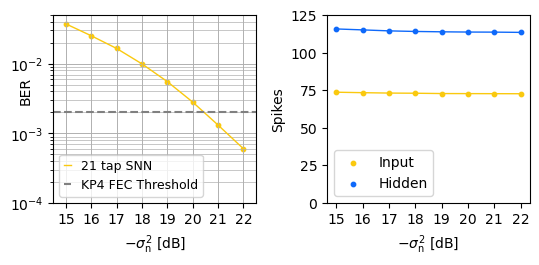

In [72]:
data = np.load(base_path / "test_bers.npy")[:-1]

color = ["#FAC90F", "#FA8D0F", "#0F69FA", "#7A6F45"]

fig, axs = plt.subplots(ncols=2, figsize=(5.5, 2.7))
axs[0].set_ylabel("BER")
axs[0].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4, 5e-2)
axs[0].set_xlim(14.5, 22.5)
axs[0].set_xticks(data[:, 0])
axs[0].plot(data[:, 0], data[:, 1], lw=1, color=color[0], label=r"21 tap SNN")
axs[0].scatter(data[:, 0], data[:, 1], color=color[0], s=10)
axs[0].hlines(2e-3, 14.5, 22.5, color="grey", ls="--", label="KP4 FEC Threshold")
axs[0].grid(which="minor", lw=0.5)
axs[0].grid(which="major", lw=0.7)
axs[0].yaxis.set_label_coords(-0.1, 0.6)
axs[0].legend(fontsize=9, handlelength=0.5)

axs[1].set_ylabel("Spikes")
axs[1].set_xlabel("$-\sigma^2_\mathrm{n}$ [dB]")
axs[1].set_xticks(data[:, 0])
axs[1].set_ylim(0, 125)
axs[1].plot(data[:, 0], data[:, 2], lw=1, color=color[0])
axs[1].scatter(data[:, 0], data[:, 2], color=color[0], s=10, label="Input")
axs[1].plot(data[:, 0], data[:, 3], lw=1, color=color[2])
axs[1].scatter(data[:, 0], data[:, 3], color=color[2], s=10, label="Hidden")
axs[1].legend()

plt.tight_layout()
plt.savefig(base_path / "ber_snr.png")